In [1]:
import os

os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/ra_joint_predictions')

In [2]:
from utils.config import Config

config = Config()

In [3]:
from dataset.joint_damage_type_dataset import joint_damage_type_dataset
from dataset.joints.joint_extractor import default_joint_extractor, feet_joint_extractor, width_based_joint_extractor
from dataset.joints.joint_extractor_factory import get_joint_extractor

hands_narrowing = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('MH', False), repeat_test = False)
hands_erosion = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('MH', True), repeat_test = False)
feet_narrowing = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('MF', False), repeat_test = False)
feet_erosion = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('MF', True), repeat_test = False)
combined_narrowing = joint_damage_type_dataset(config, joint_extractor = get_joint_extractor('MF', False))

tf_hands_j_data = hands_narrowing.get_hands_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = False)
tf_hands_e_data = hands_erosion.get_hands_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = True)
tf_feet_j_data = feet_narrowing.get_feet_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = False)
tf_feet_e_data = feet_erosion.get_feet_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = True)

2020-06-27 12:13:40,553;WARNING - Missing permissions to create directory for caching!
[{'augment': <function random_flip at 0x7f1cbaea9400>, 'p': 1}, {'augment': <function random_brightness_and_contrast at 0x7f1cbaea9488>}, {'augment': <function random_crop at 0x7f1cbaea9598>}, {'augment': <function random_gaussian_noise at 0x7f1cbaea9620>, 'p': 0.2}, {'augment': <function random_rotation at 0x7f1cbaea9510>}]
2020-06-27 12:13:45,375;WARNING - Missing permissions to create directory for caching!
[{'augment': <function random_flip at 0x7f1cbaea9400>, 'p': 1}, {'augment': <function random_brightness_and_contrast at 0x7f1cbaea9488>}, {'augment': <function random_crop at 0x7f1cbaea9598>}, {'augment': <function random_gaussian_noise at 0x7f1cbaea9620>, 'p': 0.2}, {'augment': <function random_rotation at 0x7f1cbaea9510>}]
2020-06-27 12:13:46,952;WARNING - Missing permissions to create directory for caching!
[{'augment': <function random_flip at 0x7f1cbaea9400>, 'p': 1}, {'augment': <function

In [4]:
import numpy as np

print(np.unique(hands_narrowing.outcomes, return_counts = True))
print(np.unique(hands_erosion.outcomes, return_counts = True))
print(np.unique(feet_narrowing.outcomes, return_counts = True))
print(np.unique(feet_erosion.outcomes, return_counts = True))

(array([0., 1.]), array([4093,  875]))
(array([0., 1.]), array([5085,  435]))
(array([0., 1.]), array([2792,  520]))
(array([0., 1.]), array([2802,  510]))


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, classification_report
from tensorflow import keras

def print_metrics(model_paths, ds, title, cutoff = 0.5, single_samples = False):
    models = [keras.models.load_model(model_path, compile = False) for model_path in model_paths]
    
    truths = []
    preds = []
    
    if single_samples == True:
        dataset = ds[1].unbatch()
        dataset = dataset.batch(1)
    else:
        dataset = ds[1]

    for x, y in dataset:
        y_pred = models[0].predict(x)[:, 0]
        
        for model in models[1:]:
            y_pred += model.predict(x)[:, 0]
            
        y_pred = y_pred / len(models)
    
        truths.extend(y.numpy())
        preds.extend(y_pred)
    
    truths = np.array(truths)
    preds = np.array(preds)
    
    print('Brier', np.mean(np.square(truths - preds)))
    print('AUC', roc_auc_score(truths, preds))

    precs_0 = []
    recs_0 = []
    recs_1 = []
    
    cutoffs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    
    rows = []
    
    for n in cutoffs:
        c_preds = np.zeros(preds.shape[0])
        c_preds[preds > n] = 1

        report = classification_report(truths.astype(np.int32), c_preds, output_dict = True)
        prec_0 = report['0']['precision']
        rec_0 = report['0']['recall']
        rec_1 = report['1']['recall']  
          
        precs_0.append(prec_0)
        recs_0.append(rec_0)
        recs_1.append(rec_1)
        
        rows.append({
            'cutoff': n,
            'prec_0': prec_0,
            'rec_0': rec_0,
            'rec_1': rec_1
            
        })
        
    plt.figure(figsize = (6, 4))
    plt.plot(cutoffs, precs_0, label = 'Precision 0')
    plt.plot(cutoffs, recs_0, label = 'Recall_0')
    plt.plot(cutoffs, recs_1, label = 'Recall 1')
    plt.plot([cutoff, cutoff], [0, 1])
    plt.grid()
    plt.title(title)
    plt.legend()
    plt.show()
    
    return pd.DataFrame(rows, index = np.arange(len(rows)))

Brier 0.18974413871907322
AUC 0.9526623881270526


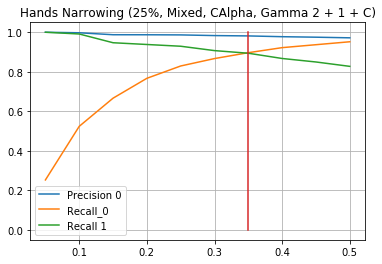

,cutoff,prec_0,rec_0,rec_1
0,0.05,1.000000,0.252833,1.000000
1,0.10,0.997305,0.524079,0.991150
2,0.15,0.987408,0.666431,0.946903
3,0.20,0.987238,0.766997,0.938053
4,0.25,0.986521,0.829320,0.929204
5,0.30,0.983133,0.866856,0.907080
6,0.35,0.981395,0.896601,0.893805
7,0.40,0.977477,0.922096,0.867257
8,0.45,0.974945,0.936969,0.849558
9,0.50,0.971800,0.951841,0.827434


In [6]:
hand_j_model_paths = ['../trained_models/narrowing/v7/narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6.h5',
                     '../trained_models/narrowing/v7/hands_narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_mixed_test_calpha.h5',
                     '../trained_models/narrowing/v7/hands_narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_test_gamma1.h5']

print_metrics(hand_j_model_paths, tf_hands_j_data, 'Hands Narrowing (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.35)

Brier 0.2003644803310283
AUC 0.9479117049813232


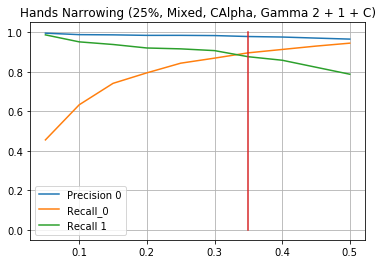

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.995356,0.455382,0.986726
1,0.10,0.987845,0.633144,0.951327
2,0.15,0.986805,0.741501,0.938053
3,0.20,0.984211,0.794618,0.920354
4,0.25,0.984298,0.843484,0.915929
5,0.30,0.983173,0.868980,0.907080
6,0.35,0.978345,0.895892,0.876106
7,0.40,0.975776,0.912890,0.858407
8,0.45,0.970436,0.929887,0.823009
9,0.50,0.965268,0.944759,0.787611


In [7]:
new_hand_j_model_paths = ['../trained_models/narrowing/v8/hands_narrowing_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_test.h5',
'../trained_models/narrowing/v8/hands_narrowing_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_gamma1_test.h5',
'../trained_models/narrowing/v8/narrowing_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_test.h5']

print_metrics(new_hand_j_model_paths, tf_hands_j_data, 'Hands Narrowing (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.35)

Brier 0.23615979878978105
AUC 0.9549714976378777


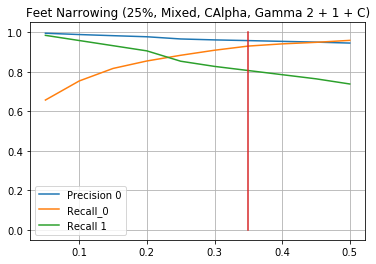

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.994958,0.657048,0.984293
1,0.10,0.988355,0.753607,0.958115
2,0.15,0.982644,0.816870,0.931937
3,0.20,0.977157,0.854606,0.905759
4,0.25,0.966019,0.883463,0.853403
5,0.30,0.961268,0.908990,0.827225
6,0.35,0.957714,0.930078,0.806283
7,0.40,0.953881,0.941176,0.785340
8,0.45,0.950000,0.948946,0.764398
9,0.50,0.945295,0.958935,0.738220


In [8]:
feet_j_model_paths = ['../trained_models/narrowing/v7/narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6.h5',
                     '../trained_models/narrowing/v7/feet_narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_mixed_test_calpha.h5',
                     '../trained_models/narrowing/v7/feet_narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_test_gamma1.h5']

print_metrics(feet_j_model_paths, tf_feet_j_data, 'Feet Narrowing (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.35)

Brier 0.23326651245349253
AUC 0.9546693319232267


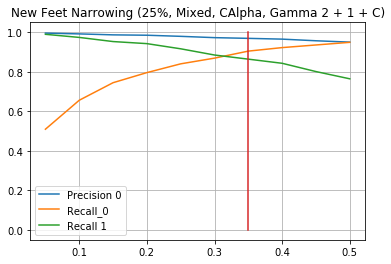

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.995662,0.509434,0.989529
1,0.10,0.991611,0.655938,0.973822
2,0.15,0.986765,0.744728,0.952880
3,0.20,0.984890,0.795782,0.942408
4,0.25,0.979301,0.840178,0.916230
5,0.30,0.972671,0.869034,0.884817
6,0.35,0.969084,0.904550,0.863874
7,0.40,0.965157,0.922309,0.842932
8,0.45,0.956867,0.935627,0.801047
9,0.50,0.950000,0.948946,0.764398


In [9]:
new_feet_j_model_paths = ['../trained_models/narrowing/v8/feet_narrowing_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_test.h5',
'../trained_models/narrowing/v8/feet_narrowing_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_gamma1_test.h5',
'../trained_models/narrowing/v8/narrowing_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_test.h5']

print_metrics(new_feet_j_model_paths, tf_feet_j_data, 'New Feet Narrowing (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.35)

Brier 0.1210671411646091
AUC 0.9022156353043116


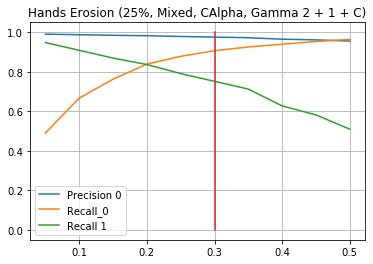

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.990315,0.490702,0.947712
1,0.10,0.987567,0.667067,0.908497
2,0.15,0.984508,0.762448,0.869281
3,0.20,0.982431,0.838632,0.836601
4,0.25,0.978610,0.878224,0.790850
5,0.30,0.975468,0.906419,0.751634
6,0.35,0.972275,0.925615,0.712418
7,0.40,0.964880,0.939412,0.627451
8,0.45,0.961283,0.953209,0.581699
9,0.50,0.955410,0.964007,0.509804


In [10]:
hands_e_filter_paths = ['../trained_models/erosion/v7/narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6.h5',
'../trained_models/erosion/v7/hands_erosion_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_mixed_test_calpha.h5',
'../trained_models/erosion/v7/hands_erosion_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_test_gamma1.h5']

print_metrics(hands_e_filter_paths, tf_hands_e_data, 'Hands Erosion (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.30)

Brier 0.12697171085876624
AUC 0.9063991123343957


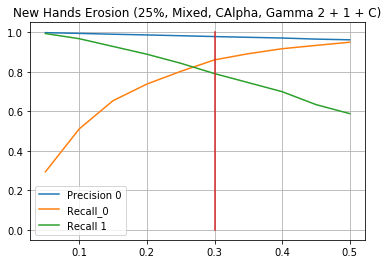

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.997963,0.293941,0.993464
1,0.10,0.994166,0.511098,0.967320
2,0.15,0.990009,0.653869,0.928105
3,0.20,0.986367,0.737852,0.888889
4,0.25,0.982366,0.802040,0.843137
5,0.30,0.978172,0.860228,0.790850
6,0.35,0.974426,0.891422,0.745098
7,0.40,0.970775,0.916617,0.699346
8,0.45,0.965261,0.933413,0.633987
9,0.50,0.961725,0.949610,0.588235


In [12]:
new_hands_e_filter_paths = ['../trained_models/erosion/v8/erosion_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_test.h5',
'../trained_models/erosion/v8/hands_erosion_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_gamma1_test.h5',
'../trained_models/erosion/v8/hands_erosion_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_test.h5']

print_metrics(new_hands_e_filter_paths, tf_hands_e_data, 'New Hands Erosion (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.30)

Brier 0.20291204844148372
AUC 0.8894373217400937


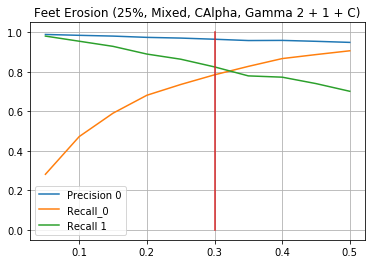

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.988764,0.281450,0.980519
1,0.10,0.984444,0.472281,0.954545
2,0.15,0.980531,0.590618,0.928571
3,0.20,0.974085,0.681237,0.889610
4,0.25,0.970464,0.735608,0.863636
5,0.30,0.964613,0.784648,0.824675
6,0.35,0.958025,0.827292,0.779221
7,0.40,0.958726,0.866738,0.772727
8,0.45,0.954128,0.886994,0.740260
9,0.50,0.948661,0.906183,0.701299


In [11]:
feet_e_filter_paths = ['../trained_models/erosion/v7/narrowing_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6.h5',
'../trained_models/erosion/v7/feet_erosion_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_mixed_test_calpha.h5',
'../trained_models/erosion/v7/feet_erosion_joint_damage_type_model_complex_rewritten_64bs_normsteps_75epochs_adamW_3e4_1e6_test_gamma1.h5']

print_metrics(feet_e_filter_paths, tf_feet_e_data, 'Feet Erosion (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.30)

Brier 0.20900596408621827
AUC 0.8927948384238362


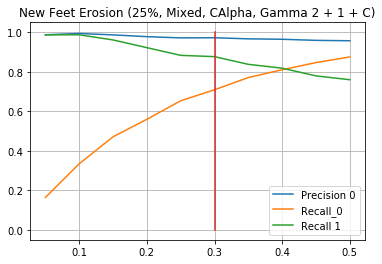

,cutoff,prec_0,rec_0,rec_1
0,0.05,0.987179,0.164179,0.987013
1,0.10,0.993671,0.334755,0.987013
2,0.15,0.986607,0.471215,0.961039
3,0.20,0.977654,0.559701,0.922078
4,0.25,0.971474,0.653518,0.883117
5,0.30,0.972222,0.708955,0.876623
6,0.35,0.966578,0.770789,0.837662
7,0.40,0.964467,0.810235,0.818182
8,0.45,0.958937,0.846482,0.779221
9,0.50,0.956876,0.875267,0.759740


In [13]:
new_feet_e_filter_paths = ['../trained_models/erosion/v8/erosion_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_test.h5',
'../trained_models/erosion/v8/feet_erosion_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_gamma1_test.h5',
'../trained_models/erosion/v8/feet_erosion_joint_damage_type_complex_gap_224x224_64bs_75epochs_adamW_3e4_1e6_5frozen_nodecay_fixed_bs_test.h5']

print_metrics(new_feet_e_filter_paths, tf_feet_e_data, 'New Feet Erosion (25%, Mixed, CAlpha, Gamma 2 + 1 + C)', cutoff = 0.30)